# Lomb-Scargle spectral estimation

## Spectral analysis of noisy sine waves

In [74]:
import numpy as np
import random
from scipy import signal

def midiToHertz(note):
    """ Converts from a midi value to a frequency """
    return 440.0 * 2.0 ** ((note - 69.0) / 12.0)

class Parameters:
    target_sampling_rate = 4410.0
    min_midi_note = 8
    max_midi_note = 80
    note_frequencies = midiToHertz(np.arange(min_midi_note, max_midi_note) - 1)
    note_periods = np.rint(target_sampling_rate / note_frequencies).astype(int)

class LombScargleRegressor:
    """ Least squares regressor based on the Lomb-Scargle method, which
    takes into account the phase changes. 

    Parameters
    ----------
    window_size : int
        Number of input samples per window
    sampling_rate : float
        Sampling rate of the input samples

    Attributes
    ----------
    taus : np.ndarray[ndim = 1]
        Phase changes of each of the given frequencies
    """
    def __init__(self, window_size, sampling_rate):
        """ Precomputes what can be precomputed for Lomb-Scargle method """
        self.window_size = window_size
        self.sampling_rate = sampling_rate
        self.taus = self.timeDelays(window_size, sampling_rate)

        """ Preprocessed variables """
        time = np.arange(window_size)
        self.cos_waves, self.sin_waves = list(), list()
        self.dens_a, self.dens_b = list(), list()
        for i, freq in enumerate(Parameters.note_frequencies):
            tmp = 2.0 * np.pi * (time - self.taus[i]) * (freq / sampling_rate)
            self.cos_waves.append(np.cos(tmp))
            self.sin_waves.append(np.sin(tmp))
            self.dens_a.append(np.sum(np.cos(tmp) ** 2))
            self.dens_b.append(np.sum(np.sin(tmp) ** 2))

    def timeDelays(self, window_size, sampling_rate):
        """ Computes the phases changes of the given frequencies """
        time = np.arange(window_size)
        taus = np.empty(len(Parameters.note_frequencies), dtype = np.double)
        for i, freq in enumerate(Parameters.note_frequencies):
            numerator = np.sin(2.0 * np.pi * time * (freq / sampling_rate)).sum()
            denominator = np.cos(2.0 * np.pi * time * (freq / sampling_rate)).sum()
            taus[i] = np.arctan(numerator / denominator) / (2.0 * np.pi * freq / sampling_rate)
        return taus

    def fit(self, psi):
        time = np.arange(self.window_size)
        Px = np.empty(len(Parameters.note_frequencies), dtype = np.double)
        for i, freq in enumerate(Parameters.note_frequencies):
            num_a = np.sum(psi * self.cos_waves[i]) ** 2
            num_b = np.sum(psi * self.sin_waves[i]) ** 2
            Px[i] = 0.5 * (num_a / self.dens_a[i] + num_b / self.dens_b[i])
        return Px

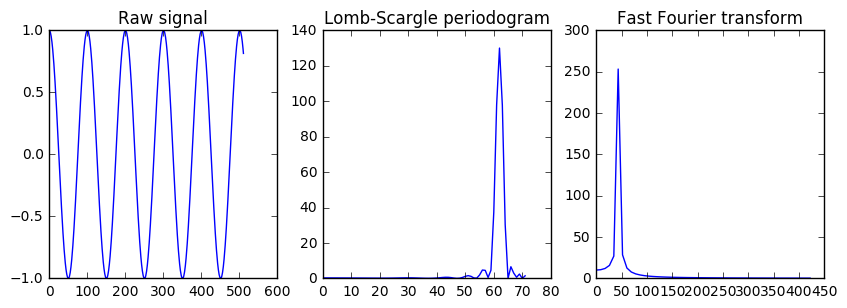

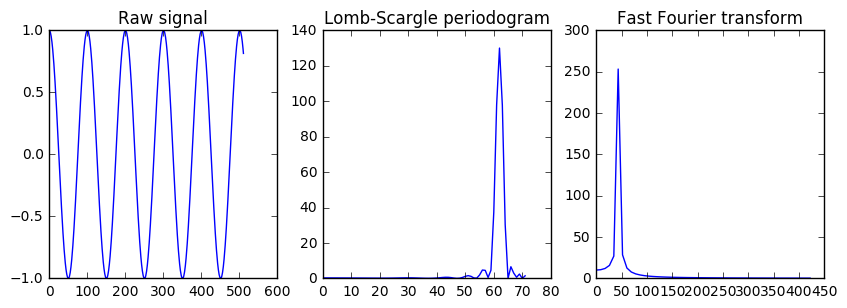

Predicted frequency : 440.000000


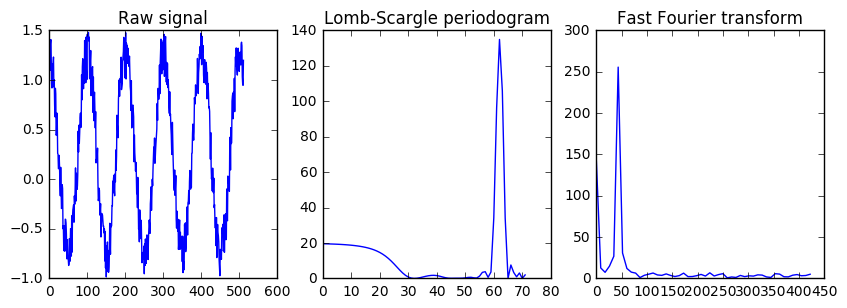

Predicted frequency : 440.000000


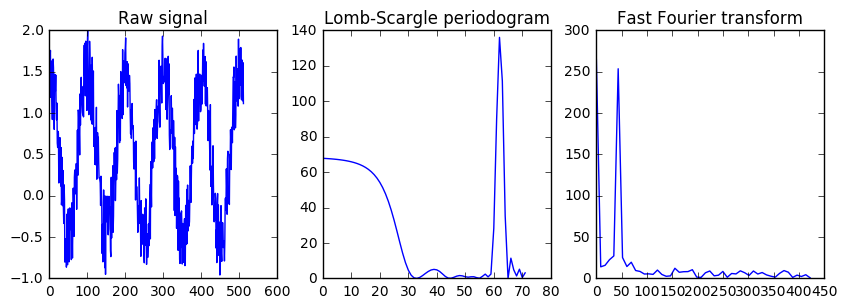

Predicted frequency : 440.000000


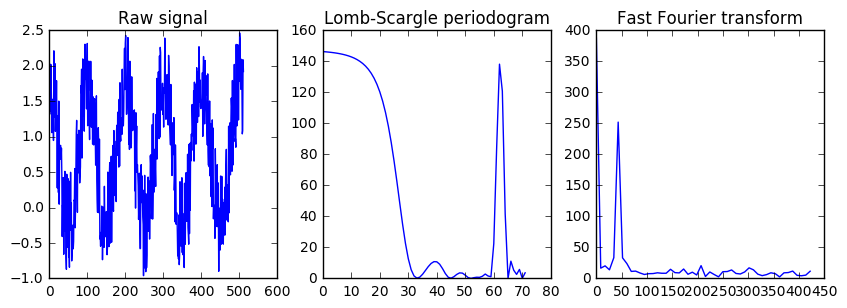

Predicted frequency : 12.249857


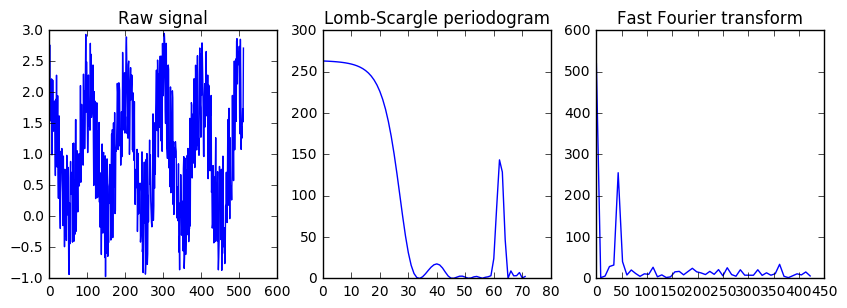

Predicted frequency : 12.249857


In [88]:
import matplotlib.pyplot as plt

window_size = 512
sampling_rate = 44100.0
regressor = LombScargleRegressor(window_size, sampling_rate)

def sinwave(freq):
    return np.cos(2.0 * np.pi * np.arange(window_size) * freq / sampling_rate)

def squarewave(freq):
    return signal.square(2.0 * np.pi * np.arange(window_size) * freq / sampling_rate)

def sawtoothwave(freq):
    return signal.sawtooth(2.0 * np.pi * np.arange(window_size) * freq / sampling_rate)

def plotSignalAndPeriodogram(signal, title = ""):
    periodogram = regressor.fit(signal)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = False)
    f.set_size_inches(10.0, 3.2)
    ax1.plot(signal)
    ax1.set_title("Raw signal")
    ax2.plot(periodogram)
    ax2.set_title("Lomb-Scargle periodogram")
    ax3.plot(np.fft.fftfreq(window_size)[:50] * Parameters.target_sampling_rate, np.abs(np.fft.fft(signal)[:50]))
    ax3.set_title("Fast Fourier transform")
    plt.show()
    print("Predicted frequency : %f" % Parameters.note_frequencies[periodogram.argmax()])
    
plotSignalAndPeriodogram(sinwave(440.0))
plotSignalAndPeriodogram(sinwave(440.0) + 0.5 * np.random.rand(window_size))
plotSignalAndPeriodogram(sinwave(440.0) + 1.0 * np.random.rand(window_size))
plotSignalAndPeriodogram(sinwave(440.0) + 1.5 * np.random.rand(window_size))
plotSignalAndPeriodogram(sinwave(440.0) + 2.0 * np.random.rand(window_size))


## Spectral analysis of oscillator-generated waves

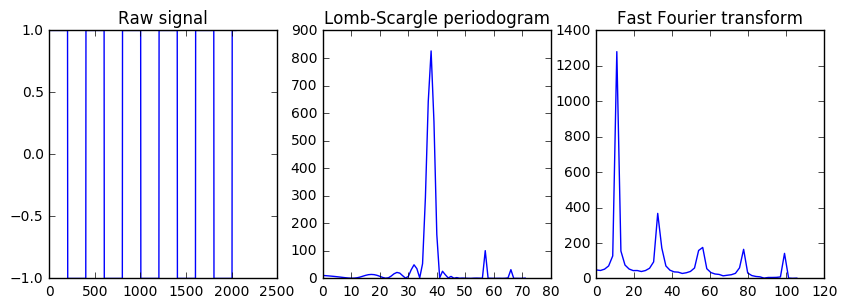

Predicted frequency : 110.000000


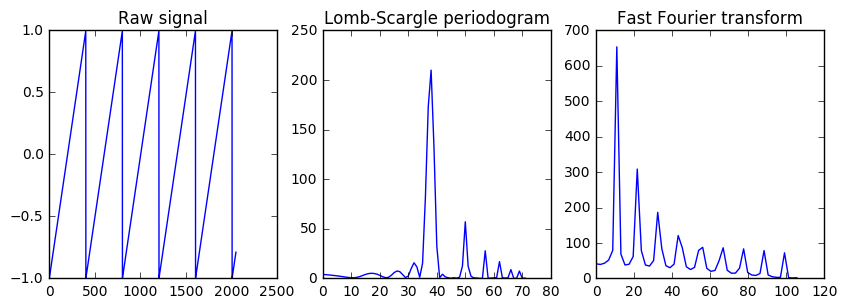

Predicted frequency : 110.000000


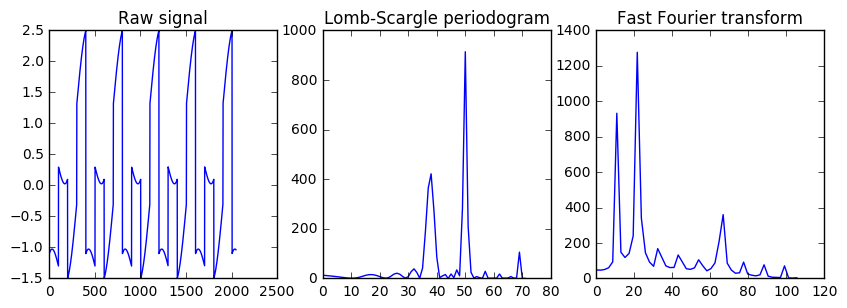

Predicted frequency : 220.000000


In [89]:
window_size = 2048
regressor = LombScargleRegressor(window_size, sampling_rate)
plotSignalAndPeriodogram(squarewave(110.0), title = "Square wave")
plotSignalAndPeriodogram(sawtoothwave(110.0), title = "Saw-tooth wave")
plotSignalAndPeriodogram(sawtoothwave(110.0) - 0.8 * squarewave(220.0) + 0.7 * sinwave(110.0))